In [1]:
#!pip install pycountry
#! pip install matplotlib
#! pip install seaborn
#! pip install plotly
#!pip install mysql-connector-python

In [1]:
import pandas as pd
import pycountry
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector


In [3]:
# Getting API 
O1 = "https://ghoapi.azureedge.net/api/NCD_BMI_30C"         # Adult Obesity
O2 = "https://ghoapi.azureedge.net/api/NCD_BMI_PLUS2C"     # Child Obesity
M1 = "https://ghoapi.azureedge.net/api/NCD_BMI_18C"        # Adult Underweight
M2 = "https://ghoapi.azureedge.net/api/NCD_BMI_MINUS2C"    # Child Thinness

# Loading Json
def get_data(url):
    raw = pd.read_json(url)
    return pd.json_normalize(raw["value"])

#  Fetch data (its actually 'O' not zero)
df_O1 = get_data(O1)
df_O2 = get_data(O2)
df_M1 = get_data(M1)
df_M2 = get_data(M2)

#  Label Age Groups
df_O1["Age"] = "Adult"
df_O2["Age"] = "Child"
df_M1["Age"] = "Adult"
df_M2["Age"] = "Child"

#  Concat datasets
df_obese = pd.concat([df_O1, df_O2])
df_mal = pd.concat([df_M1, df_M2])

#  Filter year 2012-2022
df_obese = df_obese[(df_obese["TimeDim"] >= 2012) & (df_obese["TimeDim"] <= 2022)]
df_mal = df_mal[(df_mal["TimeDim"] >= 2012) & (df_mal["TimeDim"] <= 2022)]

#  Keep important columns
keep = {
    "ParentLocation": "Region",
    "Dim1": "Gender",
    "TimeDim": "Year",
    "Low": "Lower",
    "High": "Upper",
    "NumericValue": "Value",
    "SpatialDim": "Country"
}

df_obese = df_obese[list(keep.keys()) + ["Age"]].rename(columns=keep)
df_mal = df_mal[list(keep.keys()) + ["Age"]].rename(columns=keep)

#  Clean gender labels
gender_map = {
    "SEX_BTSX": "Both",
    "SEX_MLE": "Male",
    "SEX_FMLE": "Female"
}

df_obese["Gender"] = df_obese["Gender"].replace(gender_map)
df_mal["Gender"] = df_mal["Gender"].replace(gender_map)

#  Add CI width
df_obese["CI_Width"] = df_obese["Upper"] - df_obese["Lower"]
df_mal["CI_Width"] = df_mal["Upper"] - df_mal["Lower"]

#  Obesity level
def get_obesity_level(val):
    if val >= 30: 
        return "High"
    elif val >= 25: 
        return "Moderate"
    else: 
        return "Low"

df_obese["Obesity_Level"] = df_obese["Value"].apply(get_obesity_level)

#  Malnutrition level
def get_mal_level(val):
    if val >= 20: 
        return "High"
    elif val >= 10: 
        return "Moderate"
    else: 
        return "Low"
        
# Country codes
special_cases = {
    'GLOBAL': 'Global',
    'WB_LMI': 'Low & Middle Income',
    'WB_HI': 'High Income',
    'WB_LI': 'Low Income',
    'EMR': 'Eastern Mediterranean Region',
    'EUR': 'Europe',
    'AFR': 'Africa',
    'SEAR': 'South-East Asia Region',
    'WPR': 'Western Pacific Region',
    'AMR': 'Americas Region',
    'WB_UMI': 'Upper Middle Income'
}

def alpha3_to_country(code):
    try:
        return pycountry.countries.get(alpha_3=code).name
    except:
        return special_cases.get(code, code)  # fallback to region/special

# Apply to column directly
df_obese["Country"] = df_obese["Country"].apply(alpha3_to_country)
df_mal["Country"] = df_mal["Country"].apply(alpha3_to_country)

df_mal["Malnutrition_Level"] = df_mal["Value"].apply(get_mal_level)

# 🪷 Preview headd
print(df_obese.head())
print(df_mal.head())

📁 CSV files saved successfully!
                   Region  Gender  Year     Lower     Upper     Value  \
1                  Africa  Female  2017   3.14044   5.40993   4.17558   
4   Eastern Mediterranean    Both  2018  34.92298  41.87444  38.30225   
5                  Europe    Both  2022  28.31155  34.41646  31.29533   
9                  Africa    Male  2017   1.22144   2.41332   1.76076   
13               Americas  Female  2022  31.74306  44.23656  37.80555   

         Country    Age  CI_Width Obesity_Level  
1           Chad  Adult   2.26949           Low  
4   Saudi Arabia  Adult   6.95146          High  
5        Czechia  Adult   6.10491          High  
9         Malawi  Adult   1.19188           Low  
13        Guyana  Adult  12.49350          High  
                   Region  Gender  Year     Lower     Upper     Value  \
3                Americas    Male  2017   1.10349   4.62184   2.55050   
4   Eastern Mediterranean    Male  2014   7.98273  15.97617  11.76163   
5   Easter

In [14]:
#EDA
# Shape
print("Obesity shape:", df_obese.shape)
print("Malnutrition shape:", df_mal.shape)

# Numericals
print(df_obese.describe())
print(df_mal.describe())

#  Unique values
print("Years:", df_obese["Year"].unique())
print("Regions:", df_obese["Region"].unique())


Obesity shape: (27720, 10)
Malnutrition shape: (27720, 10)
               Year         Lower         Upper         Value      CI_Width
count  27720.000000  27720.000000  27720.000000  27720.000000  27720.000000
mean    2017.000000      9.393155     17.068489     12.761041      7.675334
std        3.162335      9.893854     12.395013     10.858925      6.616899
min     2012.000000      0.077540      0.547850      0.265670      0.216700
25%     2014.000000      2.354430      7.875503      4.753960      2.926715
50%     2017.000000      6.506535     13.704380      9.944540      5.480535
75%     2020.000000     12.697755     23.986050     17.482418     10.338880
max     2022.000000     74.365370     87.868510     80.609250     40.554060
               Year         Lower         Upper         Value      CI_Width
count  27720.000000  27720.000000  27720.000000  27720.000000  27720.000000
mean    2017.000000      3.397094      8.147889      5.354451      4.750795
std        3.162335      3.90

In [17]:
# 🍬 Check missing regions
print("Missing Region in Obesity:", df_obese["Region"].isna().sum())
print("Missing Region in Malnutrition:", df_mal["Region"].isna().sum())
# View those rows
print(df_obese[df_obese["Region"].isna()].head())

Missing Region in Obesity: 1452
Missing Region in Malnutrition: 1452
    Region Gender  Year     Lower     Upper     Value          Country    Age  \
109   None   Male  2013   4.13536   4.67835   4.40509           Africa  Adult   
273   None   Male  2019  22.06974  23.98351  23.01540           Europe  Adult   
356   None   Both  2019  23.96213  25.27057  24.61187           Europe  Adult   
422   None   Male  2016  24.10158  25.29597  24.69997      High Income  Adult   
437   None   Both  2021  32.61304  34.71615  33.66089  Americas Region  Adult   

     CI_Width Obesity_Level  
109   0.54299           Low  
273   1.91377           Low  
356   1.30844           Low  
422   1.19439           Low  
437   2.10311          High  


In [18]:
country_to_region = {
    "India": "South-East Asia",
    "United States": "Americas",
    "Brazil": "Americas",
    "Nigeria": "Africa",
    "Germany": "Europe",
    "France": "Europe",
    "Australia": "Western Pacific",
    "Japan": "Western Pacific",
    "South Africa": "Africa",
    "Egypt": "Eastern Mediterranean",
    "Mexico": "Americas",
    "Russia": "Europe",
    "China": "Western Pacific",
    "Indonesia": "South-East Asia",
    "Pakistan": "Eastern Mediterranean",
    # 🧁 Add more as needed...
}

In [19]:
def fill_region(row):
    if pd.isna(row["Region"]):
        return country_to_region.get(row["Country"], "Unknown")
    return row["Region"]

# ✨ Apply to both datasets
df_obese["Region"] = df_obese.apply(fill_region, axis=1)
df_mal["Region"] = df_mal.apply(fill_region, axis=1)
print("Still missing in obese:", df_obese["Region"].isna().sum())
print("Still missing in mal:", df_mal["Region"].isna().sum())

Still missing in obese: 0
Still missing in mal: 0


In [20]:
df_obese.to_csv("final_obesity_data.csv", index=False)
df_mal.to_csv("final_malnutrition_data.csv", index=False)

print("📁 Final cleaned CSVs saved!")

📁 Final cleaned CSVs saved!


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

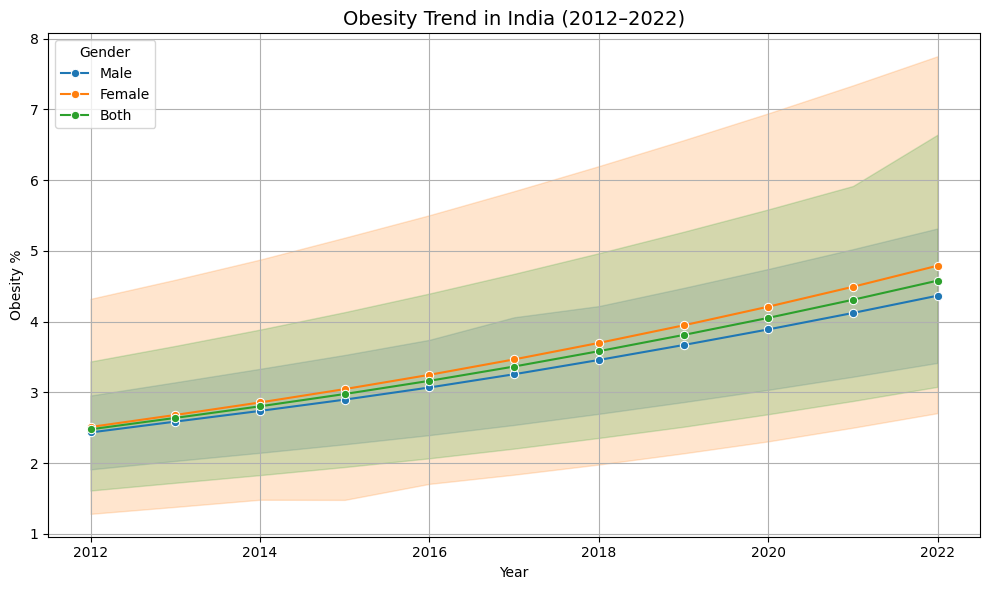

In [9]:
#  Filter only India data
india_obese = df_obese[df_obese["Country"] == "India"]

#  Lineplot 
plt.figure(figsize=(10, 6))
sns.lineplot(data=india_obese, x="Year", y="Value", hue="Gender", marker="o")

plt.title("Obesity Trend in India (2012–2022)", fontsize=14)
plt.ylabel("Obesity %")
plt.xlabel("Year")
plt.grid(True)
plt.tight_layout()
plt.show()

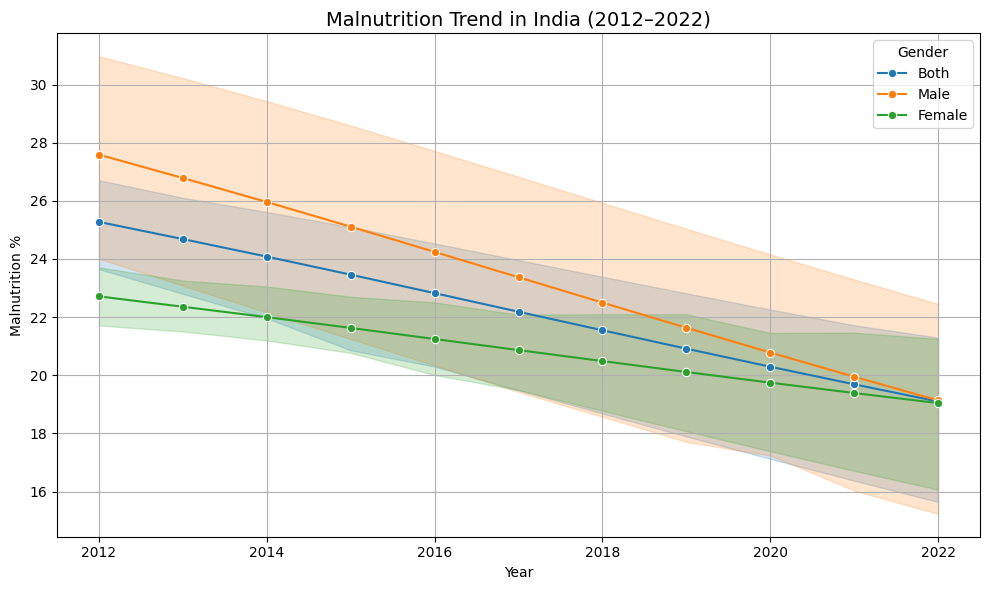

In [10]:
# 🇮🇳 Filter India malnutrition
india_mal = df_mal[df_mal["Country"] == "India"]

# 🍵 Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=india_mal, x="Year", y="Value", hue="Gender", marker="o")

plt.title("Malnutrition Trend in India (2012–2022)", fontsize=14)
plt.ylabel("Malnutrition %")
plt.xlabel("Year")
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\Shri\AppData\Local\Temp\ipykernel_18484\1673800852.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10_obese, x="Value", y="Country", palette="magma")


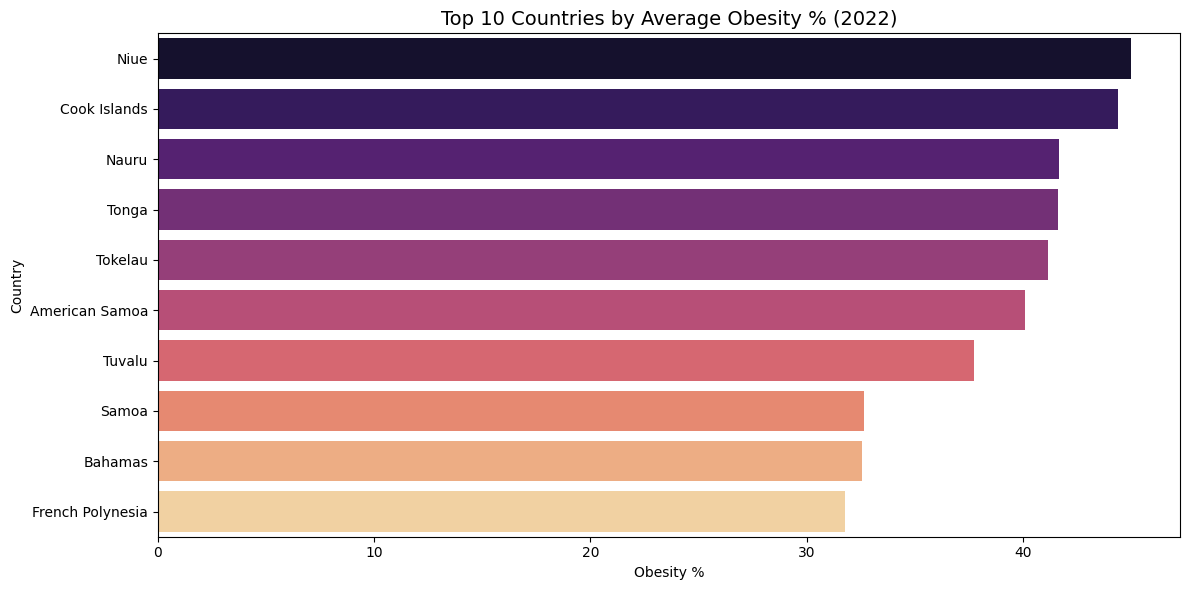

In [7]:
# 🍩 Filter for 2022
obese_2022 = df_obese[df_obese["Year"] == 2022]

# 📊 Group by country and take average (some have multiple entries by gender)
top10_obese = (
    obese_2022.groupby("Country")["Value"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

# 🎨 Barplot
plt.figure(figsize=(12, 6))
sns.barplot(data=top10_obese, x="Value", y="Country", palette="magma")

plt.title("Top 10 Countries by Average Obesity % (2022)", fontsize=14)
plt.xlabel("Obesity %")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

C:\Users\Shri\AppData\Local\Temp\ipykernel_18484\567276557.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10_mal, x="Value", y="Country", palette="coolwarm")


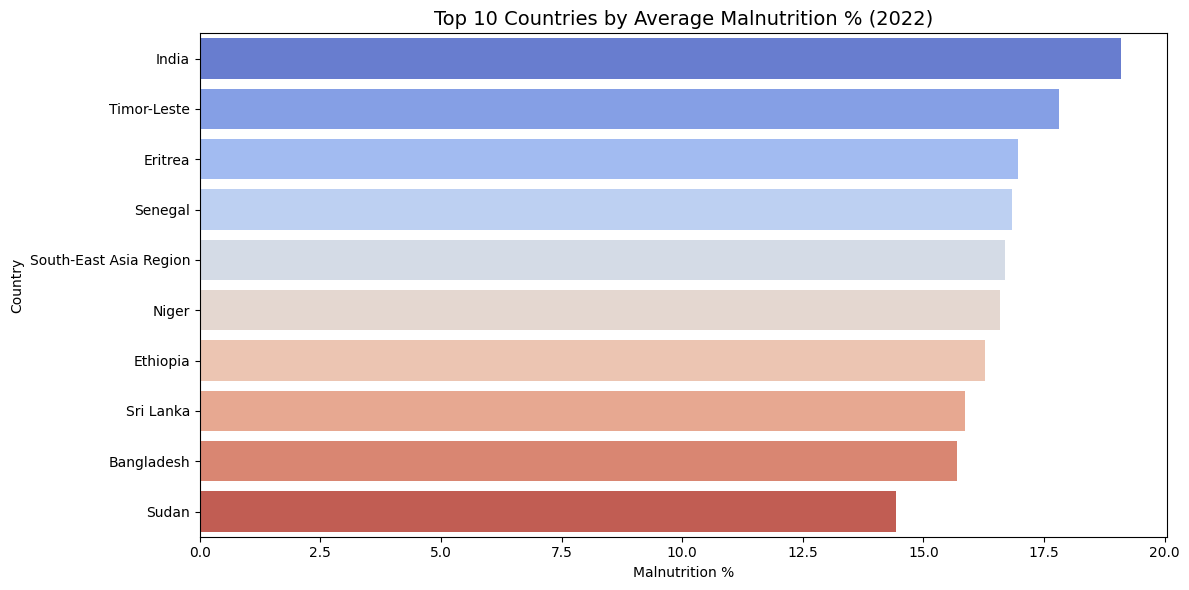

In [8]:
#Step 3.5 – Top 10 Countries by Malnutrition (2022)
# 🍵 Filter 2022 data
mal_2022 = df_mal[df_mal["Year"] == 2022]

# 🧮 Group by country & get average
top10_mal = (
    mal_2022.groupby("Country")["Value"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

# 🌈 Barplot
plt.figure(figsize=(12, 6))
sns.barplot(data=top10_mal, x="Value", y="Country", palette="coolwarm")

plt.title("Top 10 Countries by Average Malnutrition % (2022)", fontsize=14)
plt.xlabel("Malnutrition %")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


C:\Users\Shri\AppData\Local\Temp\ipykernel_18484\2320514848.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top5_worst, x="CI_Width", y="Country", palette="Reds", ax=ax[0])
C:\Users\Shri\AppData\Local\Temp\ipykernel_18484\2320514848.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top5_best, x="CI_Width", y="Country", palette="Greens", ax=ax[1])
C:\Users\Shri\AppData\Local\Temp\ipykernel_18484\2320514848.py:21: UserWarning: Glyph 128314 (\N{UP-POINTING RED TRIANGLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Shri\AppData\Local\Temp\ipykernel_18484\2320514848.py:21: UserWarning: Glyph 128315 (\N{DOWN-POINTING RED TRIANGLE}) missing from font(s) DejaV

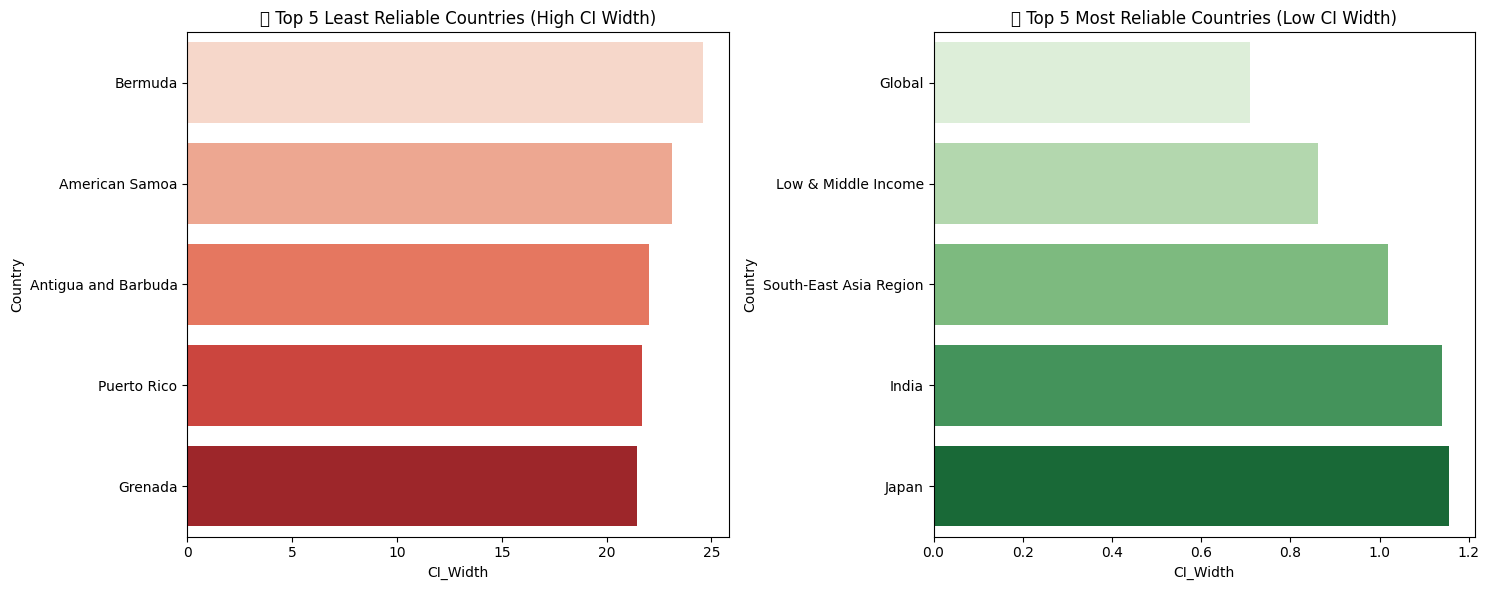

In [9]:
# 🍩 Group by country & calculate average CI_Width
ci_avg = df_obese.groupby("Country")["CI_Width"].mean().reset_index()

# 🔺 Top 5 least reliable (largest CI_Width)
top5_worst = ci_avg.sort_values(by="CI_Width", ascending=False).head(5)

# 🔻 Top 5 most reliable (smallest CI_Width)
top5_best = ci_avg.sort_values(by="CI_Width", ascending=True).head(5)

# 🎨 Plot both
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# ❗ Least reliable
sns.barplot(data=top5_worst, x="CI_Width", y="Country", palette="Reds", ax=ax[0])
ax[0].set_title("🔺 Top 5 Least Reliable Countries (High CI Width)")

# ✅ Most reliable
sns.barplot(data=top5_best, x="CI_Width", y="Country", palette="Greens", ax=ax[1])
ax[1].set_title("🔻 Top 5 Most Reliable Countries (Low CI Width)")

plt.tight_layout()
plt.show()


In [ ]:
# 🗝️ Connect to MySQL
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="root",   
    database="nutrition_db"     
)
cursor = conn.cursor()

In [ ]:
# 🍽️ Create DB if not exists
cursor.execute("CREATE DATABASE IF NOT EXISTS nutrition_db")
cursor.execute("USE nutrition_db")

# 🍩 Obesity Table
cursor.execute("""
CREATE TABLE IF NOT EXISTS obesity_data (
    Region VARCHAR(100),
    Gender VARCHAR(10),
    Year INT,
    Lower FLOAT,
    Upper FLOAT,
    Value FLOAT,
    Country VARCHAR(100),
    Age VARCHAR(20),
    CI_Width FLOAT,
    Obesity_Level VARCHAR(15)
)
""")

# 🍵 Malnutrition Table
cursor.execute("""
CREATE TABLE IF NOT EXISTS malnutrition_data (
    Region VARCHAR(100),
    Gender VARCHAR(10),
    Year INT,
    Lower FLOAT,
    Upper FLOAT,
    Value FLOAT,
    Country VARCHAR(100),
    Age VARCHAR(20),
    CI_Width FLOAT,
    Malnutrition_Level VARCHAR(15)
)
""")


In [ ]:
#  Insert obesity data
for _, row in df_obese.iterrows():
    cursor.execute("""
        INSERT INTO obesity_data (Region, Gender, Year, Lower, Upper, Value, Country, Age, CI_Width, Obesity_Level)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
    """, tuple(row))

#  Insert malnutrition data
for _, row in df_mal.iterrows():
    cursor.execute("""
        INSERT INTO malnutrition_data (Region, Gender, Year, Lower, Upper, Value, Country, Age, CI_Width, Malnutrition_Level)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
    """, tuple(row))

#  Commit changes and close connection
conn.commit()
cursor.close()
conn.close()

print(" MySQL successful!")
